# AB Test Case Study

#### Background

A recent **competitive benckmark analysis** has shown that there is margin to improve the conversion rate of the checkout funnel, so *the product and design teams* have been working together in the past weeks to come up with a restyling of the cart page that, hopefully, will increase conversions. 
The new version includes many changes to the current page and, being the business particularly data-driven, they want to change one major component at the time in order to be able to quantify any differences. 

#### Your Goal
As a data analyst you've been asked to **design and implement an experiment** to test if, after implementing the first feature, there is any **difference in conversion rate** between the old and the new cart page. 

## Design of the AB-TEST

#### Preliminary Steps

1. First of all, you need to find the **baseline conversion rate** that is, the average conversion rate of the current cart page, so you head over to Google Analytics and find that it's around 11.5%. 

2. Talking with *your stakeholders*, you all agree that you would expect to see at least a 1% increase (in absolute terms) with the new cart page, so you insert this information in an [online calculator](https://www.evanmiller.org/ab-testing/sample-size.html) in order to find the **minimum sample size** required.

3. With a baseline conversion rate of 11.5% and a minimum detectable effect of 1% (in absolute terms), you need a **minimum sample size** of at least 16,154 observations per group (control and treatment). 

4. Since your company's business cycle, from first contact to conversion, takes about 10 days on average, you decide to **run the experiment for at least three full weeks**. 

### Implementation

At this point, you reach the *software development team* that looks after the core codebase of the e-commerce platform and explain the challenge: you need them to implement a solution that allows you to **divert 50% of the traffic** to the old cart page and the remaining 50% of the traffic to its newly restyled version. 

A key aspect of this solution is that the traffic must be divided into **two groups of equal size**, and **subjects must be assigned randomly** to each one of the two groups. 

The **results** will be easily accessible in a **tabular format** with the following carachteristics: 

- each observation will be identifyied by a user id and a date value
- each user will be flagged as part of the 'control' or 'treatment' group
- for each user, it will be recorded the actual cart page name that was displayed, between 'old_cart' and 'new_cart'
- a user who converted will be flagged with a 1 

## DATA ANALYSIS

A little more than three weeks later, you retrieve your results and load them in a Python DataFrame named `df`:

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import statsmodels 

In [2]:
df_raw = pd.read_excel("ab-test-case-study.xlsx")
df = df_raw.copy()

# Initial check on the dataset

In [3]:
df.head()

,uid,date,group,page,converted
0,851104,2017-01-21,treatment,new_cart,0
1,804228,2017-01-12,treatment,new_cart,0
2,661590,2017-01-11,control,old_cart,0
3,853541,2017-01-08,control,old_cart,0
4,864975,2017-01-21,treatment,new_cart,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   uid        294478 non-null  int64         
 1   date       294478 non-null  datetime64[ns]
 2   group      294478 non-null  object        
 3   page       294478 non-null  object        
 4   converted  294478 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.2+ MB


As a first check on the **consistency of the data**, we check that the `group` and `page` variables have a one-to-one relationship. To do this, we create a summary table where we aggregate those two variables and count how many observations there are for each possible combination of their categories:

In [5]:
df.groupby(['group', 'page'], as_index=False).size()

,group,page,size
0,control,new_cart,1965
1,control,old_cart,145311
2,treatment,new_cart,145274
3,treatment,old_cart,1928


We notice that some users were assigned a 'control' label but actually saw the 'new_cart' and, vice versa, others were assigned a 'treatment' label but actually saw the 'old_cart'. This was likely caused by a **bug or an exception** in the traffic split system; luckily there aren't many of these instances, so we can filter out the inconsistencies. 

In [6]:
df = df[(df["group"]=='control')&(df["page"]=='old_cart') | (df.group=='treatment')&(df.page=='new_cart')]

In [7]:
df.groupby(['group', 'page'], as_index=False).size()

,group,page,size
0,control,old_cart,145311
1,treatment,new_cart,145274


According to our experimental design, a user id should appear only once in the dataset: if multiple sessions were recorded, then only the last session should be tracked, and a value of either 1 or 0 should be assigned to the `converted` variable accordingly. So, as a second check, we make sure that there are no duplicated values in the `uid` column: 

In [11]:
df.uid.value_counts()

773192    2
851104    1
688307    1
718297    1
838144    1
         ..
755610    1
804629    1
837875    1
889019    1
715931    1
Name: uid, Length: 290584, dtype: int64

In [14]:
duplicated=df.loc[df["uid"].duplicated()]
duplicated

,uid,date,group,page,converted
2893,773192,2017-01-14,control,old_cart,0


In [17]:
df[df['uid']==773192]

,uid,date,group,page,converted
1899,773192,2017-01-09,control,old_cart,0
2893,773192,2017-01-14,control,old_cart,0


You notice that there is one user id '773192' that appears twice in two different dates and has never converted. In order to **avoid having duplicates** in the data, we can decide to keep only the most recent record: 

In [18]:
df = df.drop(df[(df.uid == 773192) & (df.date =='2017-01-09')].index)

In [19]:
df[df['uid']==773192]

,uid,date,group,page,converted
2893,773192,2017-01-14,control,old_cart,0


As a final step, in order to get a first impression of the results, we **plot a time series** of the daily avereage conversion rate as well as a **summary table containing some useful statistics** for both the control and treatment groups. 

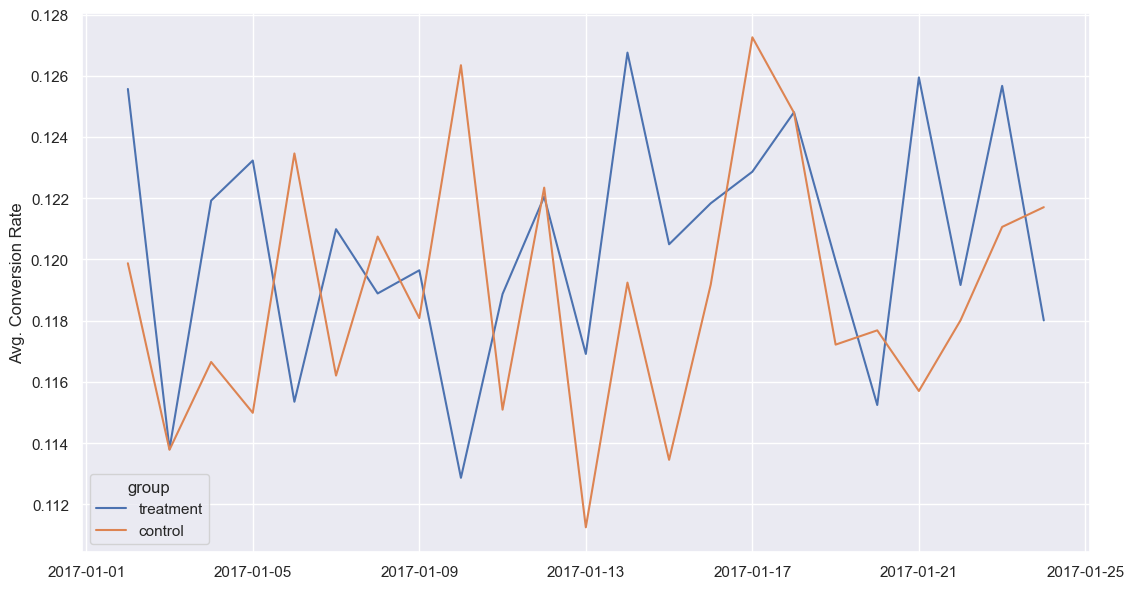

In [20]:
fig, ax = plt.subplots(figsize=(13, 7))
p = sns.lineplot(x='date', y='converted', hue='group', data=df, errorbar=None)
p.set_xlabel('')
p.set_ylabel('Avg. Conversion Rate')
plt.show()

In [21]:
df.groupby('group', as_index=False).agg({'converted': ['count', 'sum', np.mean]})

group converted                 
                 count    sum      mean
0    control    145310  17264  0.118808
1  treatment    145274  17489  0.120386

From the summary table we can immediately see that the two groups have a similar sample size, which means that the 50% traffic split process worked as expected. It is also visible that **the treatment group registered a higher number of conversions** compared to the control group. The rest of the analysis will be devoted to **finding out whether this difference is statistically significant** and if can be attributed to the restyling of the cart page. 

# PERMUTATION TEST INPLEMENTATION

### Hypothesis Testing
We decided to use a non-parametric test like a **permutation test** in order to assess if conversion rate recorded for the two groups (control and treatment) is statistically significant. 

### The Null Hypothesis

In our case, the **counter-claim** would be that there is **no difference** between the old and new cart pages and thus we expect to see no difference in conversion rate ($CR$) between the control and treatment groups. We call this counter-claim the **null hypothesis** ($H_0$), which we *assume to be true*, as opposed to the **alternative hypothesis** ($H_1$), which is the hypothesis we hope to *demonstrate to be true*. 

$$
    \begin{gather}
        H_0: CR_{treatment} \leq CR_{control} \\
        H_1: CR_{treatment} > CR_{control}
    \end{gather}
$$

#### The Test Statisitc

To determine whether or not the new cart page really is more effective at driving conversions, we need a way to quantify the difference between our null and alternative hypotheses; to do this, we use a **test statistic**.

We will use the difference in conversion rate between the two groups:

$$
    \text{Test Statistic} = CR_{treatment} - CR_{control}
$$


In [26]:
mu_control = np.mean(df[df.group=='control']['converted'])
mu_treatment = np.mean(df[df.group=='treatment']['converted'])
mu_diff = mu_treatment - mu_control
print('Observed test statistic:', mu_diff)

Observed test statistic: 0.0015782389853555567


### Permutations

In [28]:
n = 1000
mu_diff_samples = []
for i in range(n): 
    # extract a subsample of 50% of data without replacement
    df_sample1 = df.sample(frac=0.5, replace=False)
    # use set() to get indexes of rows that were not extracted from df in previous step
    ix2 = set(df.index) - set(df_sample1.index)
    # create dataframe with other 50% of data
    df_sample2 = df.loc[list(ix2)]
    # calculate difference in mean from each sample
    mu_diff_temp = np.mean(df_sample1['converted']) - np.mean(df_sample2['converted'])
    # append sampled mean difference to mu_diff_samples list
    mu_diff_samples.append(mu_diff_temp)

#### The p-value

Now, let's see where does the **observed test statistic** (red dashed line) lay with respect to the distribution of the **simulated test statistic under the null hypothesis** (blue histogram). 

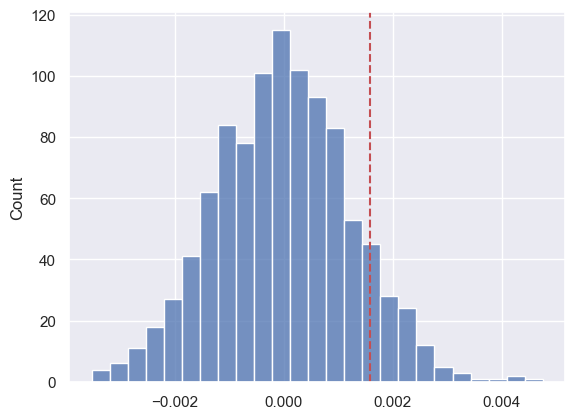

Initially Observed Test Statistic: 0.0016


In [31]:
sns.histplot(mu_diff_samples)
plt.axvline(mu_diff, 0, 1, color='r', linestyle='--')
plt.show()
print('Initially Observed Test Statistic:', f'{mu_diff:.4f}')

In [34]:
p_value = sum([el > mu_diff for el in mu_diff_samples])/n
print('p-value:',p_value)

p-value: 0.097


In [41]:
alpha = 0.05

if p_value <= alpha: 
    print('H0 rejected: the observed result is statistically significant')
else: 
    print('H0 accepted | the observed result is not statistically significant')

H0 accepted | the observed result is not statistically significant


# RESULT

As a final consideration, we can see a p-value greater than the 5% significance level, so we can accept the null hypothesis and say that there are no statistically acceptable differences between the treatment group and the control group